# Phishing Detection Using ML Modified Code Implementation

# Importing Libraries

In [1]:
# Restart the runtime after the above installation to reload the libraries with the new versions.
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm , preprocessing
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from urllib.parse import urlparse
import re
import numpy as np

import networkx as nx
import pandas as pd
import re
from urllib.parse import urlparse




# Install catboost if not already installed
!pip install catboost
from catboost import CatBoostClassifier

/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


# Loading Data

In [6]:
url = 'https://raw.githubusercontent.com/bobbydodge1/ds340w/main/DS340ProjectDataset.csv'
data = pd.read_csv(url)

data.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


# Synthesizing URL Features

In [7]:
# First, we need to extract the urls from the "body" column

data['url_string'] = data['body'].str.extract(r'((?:http|https|ftp|file)://[^\s]+|www\.[^\s]+)')

In [8]:
# Let's check if url_string was created

data.head()

,sender,receiver,date,subject,body,label,urls,url_string
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,http://whitedone.com/
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,http://www.brightmade.com
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,http://www.cnn.com/video/partners/email/index....
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,http://en.wikipedia.org/wiki/.so_%28domain_nam...
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,http://7iwfna.blu.livefilestore.com/y1pXdX3kwz...


In [9]:
# Let's hone in on url_string specifically

data['url_string'].head()

,url_string
0,http://whitedone.com/
1,http://www.brightmade.com
2,http://www.cnn.com/video/partners/email/index....
3,http://en.wikipedia.org/wiki/.so_%28domain_nam...
4,http://7iwfna.blu.livefilestore.com/y1pXdX3kwz...


In [10]:
# Let's check how many url of the 26,075 cases were extracted successfully

print("Percent Extracted Successfully:", float(data['url_string'].notnull().mean() * 100),"%")


Percent Extracted Successfully: 99.96575049233667 %


In [11]:
# So the vast majority, but not all were extracted. Let's remove the unsuccessful cases

data = data[data['url_string'].notnull()]

print("Percent Extracted Successfully:", float(data['url_string'].notnull().mean() * 100),"%")

Percent Extracted Successfully: 100.0 %


Awesome! Now, no two URL's are the same. In fact, differences in URLs are often used in current spam filters to determine whether an email is phishing or not. There are certain features of URLs that can be indicators of whether a URL is used for phishing or legit purposes. We will use the url_string column we have extracted to append these features.

CONTEXT: In parent paper implementation, traditional machine learning models were trained on URL features, such as URL Length. Each of these features for each URL either had value -1, 0, or 1. However, that data lacked the URL itself and associated email subject/message, which made implementing PPTs (see below) not possible. So, I found another dataset that contains both the URL and text, and am now adding certain features.

-1: Suggestive of phishing

0: Neutral

1: Suggestive of legit

We will now append certain features that are decipherable from the URL alone.


In [12]:
# Does URL have IP Address?

data['Has_IP_Address'] = data['url_string'].str.contains(r'http[s]?://(\d{1,3}\.){3}\d{1,3}').astype(int)
data['Has_IP_Address'] = data['Has_IP_Address'].replace({1: -1, 0: 1})

# Phishing URL's tend to, but not always, be longer. Let's check URL Length:

data['url_length'] = np.where(
    data['url_string'].str.len() < 54, 1,
    np.where(data['url_string'].str.len() > 75, -1, 0)
)

# Having_At_Symbol (-1 = '@', 1 = no '@')
data['Having_At_Symbol'] = data['url_string'].str.contains('@').astype(int)
data['Having_At_Symbol'] = data['Having_At_Symbol'].replace({1: -1, 0: 1})

# Double_Slash_Redirecting (-1 if '//' found after protocol, 1 if not)
data['Double_Slash_Redirecting'] = data['url_string'].apply(lambda u: -1 if u.find('//', 8) > 8 else 1)

# Prefix_Suffix (-1 = hyphen in domain, 1 = clean domain)
def is_valid_url(url):
  try:
    result = urlparse(url)
    return all([result.scheme, result.netloc]) # Check if scheme and netloc are present
  except ValueError:
    return False

def get_prefix_suffix(url):
    if is_valid_url(url):
        return -1 if '-' in urlparse(url).netloc else 1
    else:
        return 0  # Or any other suitable value for invalid URLs

data['Prefix_Suffix'] = data['url_string'].apply(get_prefix_suffix)

# Having_Sub_Domain
#   1 = 1 or 0 dots (e.g., example.com)
#   0 = 2 dots (e.g., mail.example.com)
#  -1 = 3+ dots (e.g., login.secure.bank.example.com)
def get_sub_domain_count(url):
    try:
        # Attempt to parse the URL
        parsed = urlparse(url)
        # Count dots in the netloc
        return parsed.netloc.count('.')
    except ValueError:
        # Handle invalid URLs by returning a default value
        return -1  # Or any other suitable value

# Apply the function to the 'url_string' column
data['Having_Sub_Domain'] = data['url_string'].apply(get_sub_domain_count)

# Categorize the Sub Domain count
data['Having_Sub_Domain'] = data['Having_Sub_Domain'].apply(lambda x: 1 if x <= 1 else 0 if x == 2 else -1)


# Shortening_Service (-1 = known shortener used, 1 = normal URL)
shorteners = r"(bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|yfrog\.com|migre\.me|ff\.im|tiny\.cc)"
data['Shortening_Service'] = data['url_string'].str.contains(shorteners).astype(int)
data['Shortening_Service'] = data['Shortening_Service'].replace({1: -1, 0: 1})


## There are also certain features that weren't incorporated in the parent paper, but may serve as indicators

# URL Encoding/Obfuscation (-1 = Obfuscation, 1 = Normal)

data['URL_Encoding'] = data['url_string'].str.contains(r'%[0-9A-Fa-f]{2}').astype(int)
data['URL_Encoding'] = data['URL_Encoding'].replace({1: -1, 0: 1})

<ipython-input-12-41d41309e8fc>:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data['Has_IP_Address'] = data['url_string'].str.contains(r'http[s]?://(\d{1,3}\.){3}\d{1,3}').astype(int)
<ipython-input-12-41d41309e8fc>:59: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data['Shortening_Service'] = data['url_string'].str.contains(shorteners).astype(int)


In [13]:
data.head()

,sender,receiver,date,subject,body,label,urls,url_string,Has_IP_Address,url_length,Having_At_Symbol,Double_Slash_Redirecting,Prefix_Suffix,Having_Sub_Domain,Shortening_Service,URL_Encoding
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,http://whitedone.com/,1,1,1,1,1,1,1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,http://www.brightmade.com,1,1,1,1,1,0,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,http://www.cnn.com/video/partners/email/index....,1,-1,1,1,1,0,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,http://en.wikipedia.org/wiki/.so_%28domain_nam...,1,1,1,1,1,0,1,-1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,http://7iwfna.blu.livefilestore.com/y1pXdX3kwz...,1,-1,1,1,1,-1,1,1


In [14]:
# Lets get a glimpse of how the feature addition went:

data[['url_length', 'Has_IP_Address','Having_At_Symbol', 'Double_Slash_Redirecting', 'Prefix_Suffix', 'Having_Sub_Domain', 'Shortening_Service', 'URL_Encoding']].apply(pd.Series.value_counts)

,url_length,Has_IP_Address,Having_At_Symbol,Double_Slash_Redirecting,Prefix_Suffix,Having_Sub_Domain,Shortening_Service,URL_Encoding
-1,2564,15.0,53.0,12.0,231,1085,935.0,100.0
0,1051,NaN,NaN,NaN,117,6756,NaN,NaN
1,8060,11660.0,11622.0,11663.0,11327,3834,10740.0,11575.0


In [15]:
# Let's make the indicator of phishing or benign more clear:

data['phishing'] = data['label']

# Remove label column from data frame

data = data.drop('label', axis=1)

data.head()

,sender,receiver,date,subject,body,urls,url_string,Has_IP_Address,url_length,Having_At_Symbol,Double_Slash_Redirecting,Prefix_Suffix,Having_Sub_Domain,Shortening_Service,URL_Encoding,phishing
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,http://whitedone.com/,1,1,1,1,1,1,1,1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,http://www.brightmade.com,1,1,1,1,1,0,1,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,http://www.cnn.com/video/partners/email/index....,1,-1,1,1,1,0,1,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,1,http://en.wikipedia.org/wiki/.so_%28domain_nam...,1,1,1,1,1,0,1,-1,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,http://7iwfna.blu.livefilestore.com/y1pXdX3kwz...,1,-1,1,1,1,-1,1,1,1


# Appending Psychological Trait Scores

Before we create samples, I want to ensure each case in the samples I take for training and testing are classified with at least one emotional appeal. I have collected 50 words possibly indicating each of the three emotional appeals: fear, urgency, or desire. We will check for the occurence of each in each combination of the emails subject and body text. I weighed this option versus an NLP approach, and while I believe the NLP approach would be more versatile, I did not have the time or computational power to reasonably conduct this operation. The code for that approach is shown in the corresponding AlternativeApproaches.ipynb

In [16]:
# Initial Filtering Out of Cases Lacking Emotional Appeals

fear_words = [
    'suspended', 'unauthorized', 'alert', 'security', 'breach', 'violation',
    'locked', 'warning', 'danger', 'risk', 'threat', 'failure',
    'fraud', 'malware', 'virus', 'infected', 'audit', 'compromised',
    'flagged', 'denied', 'hacked', 'deactivated', 'breached', 'critical',
    'error', 'leak', 'alarm', 'caution', 'exposed', 'illegal',
    'blocked', 'detection', 'criminal', 'locked', 'issues', 'violate',
    'notice', 'forbidden', 'shutdown', 'disabled', 'problem',
    'privacy', 'incident', 'warning', 'monitoring', 'firewall',
    'review', 'penalty', 'scam', 'alerting', 'threatening'
]

urgency_words = [
    'urgent', 'immediately', 'asap', 'now', 'today', 'deadline',
    'final', 'instant', 'fast', 'quickly', 'alert', 'respond',
    'verify', 'submit', 'confirm', 'action', 'required', 'ending',
    'expire', 'limited', 'last', 'prompt', 'rush', 'priority',
    'notice', 'complete', 'check', 'responding', 'processing',
    'reactivate', 'resolve', 'triggered', 'attention', 'soon',
    'waiting', 'delay', 'shortage', 'rejected', 'approved',
    'activate', 'confirming', 'access', 'verify', 'response',
    'failure', 'attempt', 'warning', 'issue', 'problem', 'alert'
]

desire_words = [
    'reward', 'bonus', 'prize', 'winner', 'gift', 'congratulations',
    'exclusive', 'offer', 'free', 'cash', 'jackpot', 'lottery',
    'promotion', 'deal', 'discount', 'sale', 'cashback', 'earnings',
    'rich', 'investment', 'money', 'income', 'profit', 'opportunity',
    'fortune', 'paid', 'credit', 'voucher', 'coupon', 'luxury',
    'trip', 'vacation', 'approved', 'refund', 'payout', 'earn',
    'selected', 'win', 'access', 'boost', 'giftcard', 'investment',
    'commission', 'redeem', 'lucky', 'premium', 'benefit',
    'advantage', 'rewarded', 'gain', 'funded'
]

In [17]:
import re

# Combine subject and body if both are present
data['full_text'] = data['subject'].fillna('') + ' ' + data['body'].fillna('')

def detect_emotion(text, keywords):
    return any(re.search(rf'\b{re.escape(kw)}\b', text.lower()) for kw in keywords)

data['Fear_Appeal'] = data['full_text'].apply(lambda x: 1 if detect_emotion(x, fear_words) else 0)
data['Urgency_Appeal'] = data['full_text'].apply(lambda x: 1 if detect_emotion(x, urgency_words) else 0)
data['Desire_Appeal'] = data['full_text'].apply(lambda x: 1 if detect_emotion(x, desire_words) else 0)



In [18]:
data.head()

,sender,receiver,date,subject,body,urls,url_string,Has_IP_Address,url_length,Having_At_Symbol,Double_Slash_Redirecting,Prefix_Suffix,Having_Sub_Domain,Shortening_Service,URL_Encoding,phishing,full_text,Fear_Appeal,Urgency_Appeal,Desire_Appeal
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,http://whitedone.com/,1,1,1,1,1,1,1,1,1,"Never agree to be a loser Buck up, your troubl...",0,1,0
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,http://www.brightmade.com,1,1,1,1,1,0,1,1,1,Befriend Jenna Jameson \nUpgrade your sex and ...,0,0,0
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,http://www.cnn.com/video/partners/email/index....,1,-1,1,1,1,0,1,1,1,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,1,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,1,http://en.wikipedia.org/wiki/.so_%28domain_nam...,1,1,1,1,1,0,1,-1,0,Re: svn commit: r619753 - in /spamassassin/tru...,0,1,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,http://7iwfna.blu.livefilestore.com/y1pXdX3kwz...,1,-1,1,1,1,-1,1,1,1,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...,0,0,0


In [19]:
data[['Fear_Appeal', 'Urgency_Appeal', 'Desire_Appeal']].apply(pd.Series.value_counts)

,Fear_Appeal,Urgency_Appeal,Desire_Appeal
0,7075,5650,6716
1,4600,6025,4959


In [20]:
# Create a mask where at least one appeal is present
has_emotion = (data[['Fear_Appeal', 'Urgency_Appeal', 'Desire_Appeal']].sum(axis=1) > 0)

# Percentage of emails with at least one emotional appeal
percent_with_emotion = has_emotion.mean() * 100

print(f"{percent_with_emotion:.2f}% of emails contain at least one emotional appeal.")

70.08% of emails contain at least one emotional appeal.


## Filtering Out Cases that Don't Contain at Least One PPT Classification

In [21]:
# I want to ensure that the sample I take contains all cases with PPTs, so that I can properly compare models with and without appropriate PPTs

filtered_data = data[data[['Fear_Appeal', 'Urgency_Appeal', 'Desire_Appeal']].sum(axis=1) > 0]

len(filtered_data)

8182

# Training/Testing Traditional ML Approaches on Data with PPT's

### Preprocessing

In [22]:
scoring = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1'}
fold_count=10

def mean_score(scoring):
    return {i:j.mean() for i,j in scoring.items()}

In [23]:
# Selecting Relevant Features:

features = ['url_length', 'Has_IP_Address', 'Having_At_Symbol', 'Double_Slash_Redirecting', 'Prefix_Suffix', 'Having_Sub_Domain', 'Shortening_Service', 'URL_Encoding', 'Fear_Appeal', 'Urgency_Appeal', 'Desire_Appeal']

X = filtered_data[features]
y = filtered_data['phishing']

### Decision Tree

In [24]:
dtree_clf=DecisionTreeClassifier()
cross_val_scores = cross_validate(dtree_clf, X, y, cv=fold_count, scoring=scoring)
dtree_score = mean_score(cross_val_scores)
print(dtree_score)

PPT_metrics_df = pd.DataFrame([{
    'Model': 'Decision Tree',
    'PPT Accuracy': dtree_score['test_accuracy'].mean(),
    'PPT Precision': dtree_score['test_precision'].mean(),
    'PPT Recall': dtree_score['test_recall'].mean()
}])

{'fit_time': np.float64(0.00879056453704834), 'score_time': np.float64(0.010711431503295898), 'test_accuracy': np.float64(0.93632598045801), 'test_recall': np.float64(0.9323474258438459), 'test_precision': np.float64(0.9429137344701456), 'test_f1': np.float64(0.9373470086228217)}


### Random Forest

In [25]:
rforest_clf=RandomForestClassifier()
cross_val_scores = cross_validate(rforest_clf, X, y, cv=fold_count, scoring=scoring)
rforest_clf_score = mean_score(cross_val_scores)
print(rforest_clf_score)

new_result = {'Model': 'Random Forest', 'PPT Accuracy': rforest_clf_score['test_accuracy'], 'PPT Precision': rforest_clf_score['test_precision'], 'PPT Recall': rforest_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.7354619979858399), 'score_time': np.float64(0.052939867973327635), 'test_accuracy': np.float64(0.937914476178535), 'test_recall': np.float64(0.9344902829867031), 'test_precision': np.float64(0.9439143413153325), 'test_f1': np.float64(0.9389658056023158)}


### Ada Booster

In [26]:
adaboost_clf=AdaBoostClassifier()
cross_val_scores = cross_validate(adaboost_clf, X, y, cv=fold_count, scoring=scoring)
adaboost_clf_score = mean_score(cross_val_scores)
print(adaboost_clf_score)

new_result = {'Model': 'Ada Booster', 'PPT Accuracy': adaboost_clf_score['test_accuracy'], 'PPT Precision': adaboost_clf_score['test_precision'], 'PPT Recall': adaboost_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.1693157434463501), 'score_time': np.float64(0.02234656810760498), 'test_accuracy': np.float64(0.8907347203190724), 'test_recall': np.float64(0.9185185816570065), 'test_precision': np.float64(0.8751108920388221), 'test_f1': np.float64(0.8956949425933924)}


### Gradient Boosting with XGBoost

In [27]:
XGB_clf=XGBClassifier()
cross_val_scores = cross_validate(XGB_clf, X, y, cv=fold_count, scoring=scoring)
XGB_clf_score= mean_score(cross_val_scores)
print(XGB_clf_score)

new_result = {'Model': 'Gradient Boosting w XGBoost', 'PPT Accuracy': XGB_clf_score['test_accuracy'], 'PPT Precision': XGB_clf_score['test_precision'], 'PPT Recall': XGB_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.112196946144104), 'score_time': np.float64(0.01885504722595215), 'test_accuracy': np.float64(0.9364477820468041), 'test_recall': np.float64(0.9325832480963747), 'test_precision': np.float64(0.9428733473699695), 'test_f1': np.float64(0.9375144193340713)}


### Gradient Booster

In [28]:
gradientBooster_clf=GradientBoostingClassifier()
cross_val_scores = cross_validate(gradientBooster_clf,X, y, cv=fold_count, scoring=scoring)
gradientBooster_clf_score= mean_score(cross_val_scores)
print(gradientBooster_clf_score)

new_result = {'Model': 'Gradient Boosting', 'PPT Accuracy': gradientBooster_clf_score['test_accuracy'], 'PPT Precision': gradientBooster_clf_score['test_precision'], 'PPT Recall': gradientBooster_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.34667220115661623), 'score_time': np.float64(0.011733436584472656), 'test_accuracy': np.float64(0.9241038776491098), 'test_recall': np.float64(0.9163865211955905), 'test_precision': np.float64(0.9347072318379634), 'test_f1': np.float64(0.924750235663476)}


### Histogram Based Gradient Boosting

In [29]:
histGradientBooster_clf = HistGradientBoostingClassifier()
cross_val_scores = cross_validate(histGradientBooster_clf,X, y, cv=fold_count, scoring=scoring)
histGradientBooster_clf_score= mean_score(cross_val_scores)
print(histGradientBooster_clf_score)

new_result = {'Model': 'Histogram Based Gradient Boosting', 'PPT Accuracy': histGradientBooster_clf_score['test_accuracy'], 'PPT Precision': histGradientBooster_clf_score['test_precision'], 'PPT Recall': histGradientBooster_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.29986724853515623), 'score_time': np.float64(0.02130420207977295), 'test_accuracy': np.float64(0.9365697329022513), 'test_recall': np.float64(0.9335356290487556), 'test_precision': np.float64(0.9422548133147328), 'test_f1': np.float64(0.9376947118780515)}


### LightGBM for Classification

In [30]:
LGBM_clf = LGBMClassifier()
cross_val_scores = cross_validate(LGBM_clf,X, y, cv=fold_count, scoring=scoring)
LGBM_clf_score= mean_score(cross_val_scores)
print(LGBM_clf_score)

new_result = {'Model': 'LightGBM', 'PPT Accuracy': LGBM_clf_score['test_accuracy'], 'PPT Precision': LGBM_clf_score['test_precision'], 'PPT Recall': LGBM_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

[LightGBM] [Info] Number of positive: 3776, number of negative: 3587
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24
[LightGBM] [Info] Number of data points in the train set: 7363, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512834 -> initscore=0.051349
[LightGBM] [Info] Start training from score 0.051349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3776, number of negative: 3587
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24
[LightGBM] [Info] Number of data points in the t

### Gradient Boosting with CatBoost

In [31]:
catBoost_classifier = CatBoostClassifier(verbose=0, n_estimators=100)
cross_val_scores = cross_validate(catBoost_classifier,X, y, cv=fold_count, scoring=scoring)
catBoost_classifier_score= mean_score(cross_val_scores)
print(catBoost_classifier_score)

new_result = {'Model': 'Gradient Boosting w CatBoost', 'PPT Accuracy': catBoost_classifier_score['test_accuracy'], 'PPT Precision': catBoost_classifier_score['test_precision'], 'PPT Recall': catBoost_classifier_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.20739588737487794), 'score_time': np.float64(0.0110093355178833), 'test_accuracy': np.float64(0.9360810338805449), 'test_recall': np.float64(0.930202863961814), 'test_precision': np.float64(0.9443374699366422), 'test_f1': np.float64(0.9369571203227537)}


### kNN

In [32]:
KNeighbors_clf=KNeighborsClassifier(3)
cross_val_scores = cross_validate(KNeighbors_clf, X, y, cv=fold_count, scoring=scoring)
KNeighbors_clf_score = mean_score(cross_val_scores)
print(KNeighbors_clf_score)

new_result = {'Model': 'kNN', 'PPT Accuracy': KNeighbors_clf_score['test_accuracy'], 'PPT Precision': KNeighbors_clf_score['test_precision'], 'PPT Recall': KNeighbors_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.01451728343963623), 'score_time': np.float64(0.09856925010681153), 'test_accuracy': np.float64(0.9253206994038289), 'test_recall': np.float64(0.9394817592908284), 'test_precision': np.float64(0.9172575532748587), 'test_f1': np.float64(0.9277643142633497)}


### Logistic Regression

In [33]:
logistic_clf=LogisticRegression(random_state=1)
cross_val_scores = cross_validate(logistic_clf, X, y, cv=fold_count, scoring=scoring)
logistic_clf_score = mean_score(cross_val_scores)
print(logistic_clf_score)

new_result = {'Model': 'Logistic Regression', 'PPT Accuracy': logistic_clf_score['test_accuracy'], 'PPT Precision': logistic_clf_score['test_precision'], 'PPT Recall': logistic_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.03568034172058106), 'score_time': np.float64(0.00976102352142334), 'test_accuracy': np.float64(0.8678797567550625), 'test_recall': np.float64(0.9051829753381068), 'test_precision': np.float64(0.8480266740051657), 'test_f1': np.float64(0.8747156893613729)}


### NN

In [34]:
neural_clf=MLPClassifier(hidden_layer_sizes=(33,),max_iter=500)
cross_val_scores = cross_validate(neural_clf, X, y, cv=fold_count, scoring=scoring)
neural_clf_score = mean_score(cross_val_scores)
print(neural_clf_score)

new_result = {'Model': 'Neural Network', 'PPT Accuracy': neural_clf_score['test_accuracy'], 'PPT Precision': neural_clf_score['test_precision'], 'PPT Recall': neural_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(3.2876657485961913), 'score_time': np.float64(0.010667037963867188), 'test_accuracy': np.float64(0.9340038391383135), 'test_recall': np.float64(0.9292510512558246), 'test_precision': np.float64(0.9412183278285469), 'test_f1': np.float64(0.9349851624757255)}


### SVM

In [35]:
###linear
linear_clf = svm.SVC(kernel='linear')
cross_val_scores = cross_validate(linear_clf, X, y, cv=fold_count, scoring=scoring)
linear_svc_clf_score = mean_score(cross_val_scores)
print(linear_svc_clf_score)

new_result = {'Model': 'SVM Linear', 'PPT Accuracy': linear_svc_clf_score['test_accuracy'], 'PPT Precision': linear_svc_clf_score['test_precision'], 'PPT Recall': linear_svc_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

###poly
poly_clf = svm.SVC(kernel='poly')
cross_val_scores = cross_validate(poly_clf, X, y, cv=fold_count, scoring=scoring)
poly_svc_clf_score = mean_score(cross_val_scores)
print(poly_svc_clf_score)

new_result = {'Model': 'SVM Poly', 'PPT Accuracy': poly_svc_clf_score['test_accuracy'], 'PPT Precision': poly_svc_clf_score['test_precision'], 'PPT Recall': poly_svc_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

###rbf
rbf_clf = svm.SVC(kernel='rbf')
cross_val_scores = cross_validate(rbf_clf, X, y, cv=fold_count, scoring=scoring)
rbf_svc_clf_score = mean_score(cross_val_scores)
print(rbf_svc_clf_score)

new_result = {'Model': 'SVM RBF', 'PPT Accuracy': rbf_svc_clf_score['test_accuracy'], 'PPT Precision': rbf_svc_clf_score['test_precision'], 'PPT Recall': rbf_svc_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

###sigmoid
sigmoid_clf = svm.SVC(kernel='sigmoid')
cross_val_scores = cross_validate(sigmoid_clf, X, y, cv=fold_count, scoring=scoring)
sigmoid_svc_clf_score = mean_score(cross_val_scores)
print(sigmoid_svc_clf_score)

new_result = {'Model': 'SVM Sigmoid', 'PPT Accuracy': sigmoid_svc_clf_score['test_accuracy'], 'PPT Precision': sigmoid_svc_clf_score['test_precision'], 'PPT Recall': sigmoid_svc_clf_score['test_recall']}
PPT_metrics_df = pd.concat([PPT_metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(1.3158995151519775), 'score_time': np.float64(0.06853196620941163), 'test_accuracy': np.float64(0.87008547008547), 'test_recall': np.float64(0.8799312421866121), 'test_precision': np.float64(0.8689206493803987), 'test_f1': np.float64(0.8735817409009069)}
{'fit_time': np.float64(1.038733220100403), 'score_time': np.float64(0.04125247001647949), 'test_accuracy': np.float64(0.9344931352266317), 'test_recall': np.float64(0.9321087623593589), 'test_precision': np.float64(0.9399174786972042), 'test_f1': np.float64(0.9356551697120183)}
{'fit_time': np.float64(0.4373384952545166), 'score_time': np.float64(0.06606912612915039), 'test_accuracy': np.float64(0.933392890727854), 'test_recall': np.float64(0.9311563814069782), 'test_precision': np.float64(0.938679369687508), 'test_f1': np.float64(0.9345708572350698)}
{'fit_time': np.float64(2.533977174758911), 'score_time': np.float64(0.19792213439941406), 'test_accuracy': np.float64(0.653195351239361), 'test_recall': np.float

# Training/Testing Traditional ML Approaches on Data without PPT's

### Preprocessing

In [36]:
scoring = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1'}
fold_count=10

def mean_score(scoring):
    return {i:j.mean() for i,j in scoring.items()}

In [37]:
# Selecting Relevant Features:

features = ['url_length', 'Has_IP_Address', 'Having_At_Symbol', 'Double_Slash_Redirecting', 'Prefix_Suffix', 'Having_Sub_Domain', 'Shortening_Service', 'URL_Encoding']

X = filtered_data[features]
y = filtered_data['phishing']

### Decision Tree

In [38]:
dtree_clf=DecisionTreeClassifier()
cross_val_scores = cross_validate(dtree_clf, X, y, cv=fold_count, scoring=scoring)
dtree_score = mean_score(cross_val_scores)
print(dtree_score)

metrics_df = pd.DataFrame([{
    'Model': 'Decision Tree',
    'Accuracy': dtree_score['test_accuracy'].mean(),
    'Precision': dtree_score['test_precision'].mean(),
    'Recall': dtree_score['test_recall'].mean()
}])

{'fit_time': np.float64(0.005849003791809082), 'score_time': np.float64(0.010914206504821777), 'test_accuracy': np.float64(0.9206822381639007), 'test_recall': np.float64(0.924488578247528), 'test_precision': np.float64(0.9216990073516277), 'test_f1': np.float64(0.9225677242872438)}


### Random Forest

In [39]:
rforest_clf=RandomForestClassifier()
cross_val_scores = cross_validate(rforest_clf, X, y, cv=fold_count, scoring=scoring)
rforest_clf_score = mean_score(cross_val_scores)
print(rforest_clf_score)

new_result = {'Model': 'Random Forest', 'Accuracy': rforest_clf_score['test_accuracy'], 'Precision': rforest_clf_score['test_precision'], 'Recall': rforest_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.24771604537963868), 'score_time': np.float64(0.021776294708251952), 'test_accuracy': np.float64(0.9206822381639007), 'test_recall': np.float64(0.924488578247528), 'test_precision': np.float64(0.9216990073516277), 'test_f1': np.float64(0.9225677242872438)}


### Ada Booster

In [40]:
adaboost_clf=AdaBoostClassifier()
cross_val_scores = cross_validate(adaboost_clf, X, y, cv=fold_count, scoring=scoring)
adaboost_clf_score = mean_score(cross_val_scores)
print(adaboost_clf_score)

new_result = {'Model': 'Ada Booster', 'Accuracy': adaboost_clf_score['test_accuracy'], 'Precision': adaboost_clf_score['test_precision'], 'Recall': adaboost_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.15100412368774413), 'score_time': np.float64(0.02258145809173584), 'test_accuracy': np.float64(0.8977098017440316), 'test_recall': np.float64(0.9192436640527333), 'test_precision': np.float64(0.8861654887341486), 'test_f1': np.float64(0.9020697628666241)}


### Gradient Boosting with XGBoost

In [41]:
XGB_clf=XGBClassifier()
cross_val_scores = cross_validate(XGB_clf, X, y, cv=fold_count, scoring=scoring)
XGB_clf_score= mean_score(cross_val_scores)
print(XGB_clf_score)

new_result = {'Model': 'Gradient Boosting w XGBoost', 'Accuracy': XGB_clf_score['test_accuracy'], 'Precision': XGB_clf_score['test_precision'], 'Recall': XGB_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.08718667030334473), 'score_time': np.float64(0.019950246810913085), 'test_accuracy': np.float64(0.9194597442763701), 'test_recall': np.float64(0.924488578247528), 'test_precision': np.float64(0.9193525147977082), 'test_f1': np.float64(0.921464667694542)}


### Gradient_Booster

In [42]:
gradientBooster_clf=GradientBoostingClassifier()
cross_val_scores = cross_validate(gradientBooster_clf,X, y, cv=fold_count, scoring=scoring)
gradientBooster_clf_score= mean_score(cross_val_scores)
print(gradientBooster_clf_score)

new_result = {'Model': 'Gradient Boosting', 'Accuracy': gradientBooster_clf_score['test_accuracy'], 'Precision': gradientBooster_clf_score['test_precision'], 'Recall': gradientBooster_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.3177721738815308), 'score_time': np.float64(0.012828421592712403), 'test_accuracy': np.float64(0.919460192076329), 'test_recall': np.float64(0.9254403909535174), 'test_precision': np.float64(0.9186453820132705), 'test_f1': np.float64(0.9215691305179041)}


### Histogram-Based Gradient Boosting

In [43]:
histGradientBooster_clf = HistGradientBoostingClassifier()
cross_val_scores = cross_validate(histGradientBooster_clf,X, y, cv=fold_count, scoring=scoring)
histGradientBooster_clf_score= mean_score(cross_val_scores)
print(histGradientBooster_clf_score)

new_result = {'Model': 'Histogram Based Gradient Boosting', 'Accuracy': histGradientBooster_clf_score['test_accuracy'], 'Precision': histGradientBooster_clf_score['test_precision'], 'Recall': histGradientBooster_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.1926708698272705), 'score_time': np.float64(0.019627881050109864), 'test_accuracy': np.float64(0.9190926975768052), 'test_recall': np.float64(0.9218672576429139), 'test_precision': np.float64(0.9209272810335806), 'test_f1': np.float64(0.9209212998959211)}


### LightGBM for Classification

In [44]:
LGBM_clf = LGBMClassifier()
cross_val_scores = cross_validate(LGBM_clf,X, y, cv=fold_count, scoring=scoring)
LGBM_clf_score= mean_score(cross_val_scores)
print(LGBM_clf_score)

new_result = {'Model': 'LightGBM', 'Accuracy': LGBM_clf_score['test_accuracy'], 'Precision': LGBM_clf_score['test_precision'], 'Recall': LGBM_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

[LightGBM] [Info] Number of positive: 3776, number of negative: 3587
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 7363, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512834 -> initscore=0.051349
[LightGBM] [Info] Start training from score 0.051349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Gradient Boosting with CatBoost

In [45]:
catBoost_classifier = CatBoostClassifier(verbose=0, n_estimators=100)
cross_val_scores = cross_validate(catBoost_classifier,X, y, cv=fold_count, scoring=scoring)
catBoost_classifier_score= mean_score(cross_val_scores)
print(catBoost_classifier_score)

new_result = {'Model': 'Gradient Boosting w CatBoost', 'Accuracy': catBoost_classifier_score['test_accuracy'], 'Precision': catBoost_classifier_score['test_precision'], 'Recall': catBoost_classifier_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.2305220365524292), 'score_time': np.float64(0.0162431001663208), 'test_accuracy': np.float64(0.9206822381639007), 'test_recall': np.float64(0.924488578247528), 'test_precision': np.float64(0.9216990073516277), 'test_f1': np.float64(0.9225677242872438)}


### KNN

In [46]:
KNeighbors_clf=KNeighborsClassifier(3)
cross_val_scores = cross_validate(KNeighbors_clf, X, y, cv=fold_count, scoring=scoring)
KNeighbors_clf_score = mean_score(cross_val_scores)
print(KNeighbors_clf_score)

new_result = {'Model': 'kNN', 'Accuracy': KNeighbors_clf_score['test_accuracy'], 'Precision': KNeighbors_clf_score['test_precision'], 'Recall': KNeighbors_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.009485507011413574), 'score_time': np.float64(0.08395619392395019), 'test_accuracy': np.float64(0.9065154894005749), 'test_recall': np.float64(0.9306767814524377), 'test_precision': np.float64(0.8976122533386844), 'test_f1': np.float64(0.9116541646293571)}


### Logistic Regression

In [47]:
logistic_clf=LogisticRegression(random_state=1)
cross_val_scores = cross_validate(logistic_clf, X, y, cv=fold_count, scoring=scoring)
logistic_clf_score = mean_score(cross_val_scores)
print(logistic_clf_score)

new_result = {'Model': 'Logistic Regression', 'Accuracy': logistic_clf_score['test_accuracy'], 'Precision': logistic_clf_score['test_precision'], 'Recall': logistic_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.02895331382751465), 'score_time': np.float64(0.010983681678771973), 'test_accuracy': np.float64(0.8967300154341717), 'test_recall': np.float64(0.9151954767587226), 'test_precision': np.float64(0.887668382336463), 'test_f1': np.float64(0.90072382110137)}


### NN

In [48]:
neural_clf=MLPClassifier(hidden_layer_sizes=(33,),max_iter=500)
cross_val_scores = cross_validate(neural_clf, X, y, cv=fold_count, scoring=scoring)
neural_clf_score = mean_score(cross_val_scores)
print(neural_clf_score)

new_result = {'Model': 'Neural Network', 'Accuracy': neural_clf_score['test_accuracy'], 'Precision': neural_clf_score['test_precision'], 'Recall': neural_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(2.8546542644500734), 'score_time': np.float64(0.01114327907562256), 'test_accuracy': np.float64(0.9179936472112512), 'test_recall': np.float64(0.9194828957836118), 'test_precision': np.float64(0.9209693950986981), 'test_f1': np.float64(0.919760469130696)}


### SVM

In [49]:
###linear
linear_clf = svm.SVC(kernel='linear')
cross_val_scores = cross_validate(linear_clf, X, y, cv=fold_count, scoring=scoring)
linear_svc_clf_score = mean_score(cross_val_scores)
print(linear_svc_clf_score)

new_result = {'Model': 'SVM Linear', 'Accuracy': linear_svc_clf_score['test_accuracy'], 'Precision': linear_svc_clf_score['test_precision'], 'Recall': linear_svc_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

###poly
poly_clf = svm.SVC(kernel='poly')
cross_val_scores = cross_validate(poly_clf, X, y, cv=fold_count, scoring=scoring)
poly_svc_clf_score = mean_score(cross_val_scores)
print(poly_svc_clf_score)

new_result = {'Model': 'SVM Poly', 'Accuracy': poly_svc_clf_score['test_accuracy'], 'Precision': poly_svc_clf_score['test_precision'], 'Recall': poly_svc_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

###rbf
rbf_clf = svm.SVC(kernel='rbf')
cross_val_scores = cross_validate(rbf_clf, X, y, cv=fold_count, scoring=scoring)
rbf_svc_clf_score = mean_score(cross_val_scores)
print(rbf_svc_clf_score)

new_result = {'Model': 'SVM RBF', 'Accuracy': rbf_svc_clf_score['test_accuracy'], 'Precision': rbf_svc_clf_score['test_precision'], 'Recall': rbf_svc_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

###sigmoid
sigmoid_clf = svm.SVC(kernel='sigmoid')
cross_val_scores = cross_validate(sigmoid_clf, X, y, cv=fold_count, scoring=scoring)
sigmoid_svc_clf_score = mean_score(cross_val_scores)
print(sigmoid_svc_clf_score)

new_result = {'Model': 'SVM Sigmoid', 'Accuracy': sigmoid_svc_clf_score['test_accuracy'], 'Precision': sigmoid_svc_clf_score['test_precision'], 'Recall': sigmoid_svc_clf_score['test_recall']}
metrics_df = pd.concat([metrics_df, pd.DataFrame([new_result])], ignore_index=True)

{'fit_time': np.float64(0.7794760704040528), 'score_time': np.float64(0.06003139019012451), 'test_accuracy': np.float64(0.8382028593520034), 'test_recall': np.float64(0.9151954767587226), 'test_precision': np.float64(0.8044128532430618), 'test_f1': np.float64(0.8545224092860071)}
{'fit_time': np.float64(0.46749560832977294), 'score_time': np.float64(0.04543821811676026), 'test_accuracy': np.float64(0.9206822381639007), 'test_recall': np.float64(0.924488578247528), 'test_precision': np.float64(0.9216990073516277), 'test_f1': np.float64(0.9225677242872438)}
{'fit_time': np.float64(0.39004318714141845), 'score_time': np.float64(0.06463651657104492), 'test_accuracy': np.float64(0.9198264924426294), 'test_recall': np.float64(0.9237742925332423), 'test_precision': np.float64(0.9207190994372493), 'test_f1': np.float64(0.9217250883754815)}
{'fit_time': np.float64(4.459214568138123), 'score_time': np.float64(0.23746654987335206), 'test_accuracy': np.float64(0.524914843374501), 'test_recall': np

# Attempting Network Based Approaches

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter

# Optional: reduce size for faster testing
# data = data.sample(n=5000, random_state=42).reset_index(drop=True)

# Step 1: Tokenize each URL into sets of tokens
def tokenize_url(url):
    return set(re.split(r'\W+', url.lower())) - {''}

sample_data = data.sample(n=2000, random_state=42)

token_sets = sample_data['url_string'].apply(tokenize_url)
labels = sample_data['phishing'].values


In [51]:
# Step 2: Compute token-overlap-based similarity & vote

def get_phishy_neighbor_score(i, token_sets, labels, k=10):
    this_tokens = token_sets[i]
    similarities = []

    for j, other_tokens in enumerate(token_sets):
        if i == j:
            continue
        # Simple Jaccard similarity
        intersection = len(this_tokens & other_tokens)
        union = len(this_tokens | other_tokens)
        score = intersection / union if union > 0 else 0
        similarities.append((j, score))

    # Get top-k by similarity
    top_k = sorted(similarities, key=lambda x: x[1], reverse=True)[:k]
    top_k_indices = [idx for idx, _ in top_k]
    return np.mean([labels[idx] for idx in top_k_indices])

# Step 3: Generate phishy scores
phishy_scores = []

# Change the loop to iterate over the indices of token_sets:
for i in token_sets.index:
    score = get_phishy_neighbor_score(i, token_sets, labels, k=10)
    phishy_scores.append(score)
    if i % 500 == 0:
        print(f"Processed {i}/{len(sample_data)}")

sample_data['phishy_score'] = phishy_scores


Processed 0/2000
Processed 500/2000


In [52]:
# Step 4: Train & Evaluate

# Use the sample_data DataFrame where 'phishy_score' was added
X = sample_data[['phishy_score']]
y = sample_data['phishing']

clf = RandomForestClassifier()
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall':'recall'} # Define scoring metrics as a dictionary
cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring) # Use cross_validate to calculate multiple scores

print(f"Accuracy:      {cv_results['test_accuracy'].mean():.4f}")
print(f"Precision:     {cv_results['test_precision'].mean():.4f}")
print(f"Recall:        {cv_results['test_recall'].mean():.4f}")


Accuracy:      0.9905
Precision:     1.0000
Recall:        0.9834


In [53]:
network_metrics_df = pd.DataFrame([{
    'Model': 'Network Approach',
    'Accuracy': cv_results['test_accuracy'].mean(),
    'Precision': cv_results['test_precision'].mean(),
    'Recall': cv_results['test_recall'].mean(),
    'PPT Accuracy': 'N/A',
    'PPT Precision': 'N/A',
    'PPT Recall': 'N/A'
}])

network_metrics_df

,Model,Accuracy,Precision,Recall,PPT Accuracy,PPT Precision,PPT Recall
0,Network Approach,0.9905,1.0,0.983375,N/A,N/A,N/A


## Analyzing Results Across All Methods

In [54]:
# Observe Performance of Traditional Models with and without PPTs

full_TraditionalMLmetrics_df = pd.merge(metrics_df, PPT_metrics_df, on='Model')

full_TraditionalMLmetrics_df

,Model,Accuracy,Precision,Recall,PPT Accuracy,PPT Precision,PPT Recall
0,Decision Tree,0.920682,0.921699,0.924489,0.936326,0.942914,0.932347
1,Random Forest,0.920682,0.921699,0.924489,0.937914,0.943914,0.934490
2,Ada Booster,0.897710,0.886165,0.919244,0.890735,0.875111,0.918519
3,Gradient Boosting w XGBoost,0.919460,0.919353,0.924489,0.936448,0.942873,0.932583
4,Gradient Boosting,0.919460,0.918645,0.925440,0.924104,0.934707,0.916387
5,Histogram Based Gradient Boosting,0.919093,0.920927,0.921867,0.936570,0.942255,0.933536
6,LightGBM,0.919949,0.920300,0.924489,0.936936,0.942930,0.933536
7,Gradient Boosting w CatBoost,0.920682,0.921699,0.924489,0.936081,0.944337,0.930203
8,kNN,0.906515,0.897612,0.930677,0.925321,0.917258,0.939482
9,Logistic Regression,0.896730,0.887668,0.915195,0.867880,0.848027,0.905183


In [55]:
# Average Accuracy between Traditional ML Models with and without PPTs versus Network-Based Approach

print("Accuracy:")
print("Average Accuracy for Models with PPTs:", full_TraditionalMLmetrics_df['PPT Accuracy'].mean())
print("Average Accuracy for Models without PPTs:", full_TraditionalMLmetrics_df['Accuracy'].mean())
print("Accuracy of Network Based Approach:", network_metrics_df['Accuracy'])

print("Precision:")
print("Average Precision for Models with PPTs:", full_TraditionalMLmetrics_df['PPT Precision'].mean())
print("Average Precision for Models without PPTs:", full_TraditionalMLmetrics_df['Precision'].mean())
print("Precision of Network Based Approach:", network_metrics_df['Precision'])

print("Recall:")
print("Average Recall for Models with PPTs:", full_TraditionalMLmetrics_df['PPT Recall'].mean())
print("Average Recall for Models without PPTs:", full_TraditionalMLmetrics_df['Recall'].mean())
print("Recall of Network Based Approach:", network_metrics_df['Recall'])



Accuracy:
Average Accuracy for Models with PPTs: 0.9035656619030702
Average Accuracy for Models without PPTs: 0.8841722318250435
Accuracy of Network Based Approach: 0    0.9905
Name: Accuracy, dtype: float64
Precision:
Average Precision for Models with PPTs: 0.9035252099331058
Average Precision for Models without PPTs: 0.8832228291211397
Precision of Network Based Approach: 0    1.0
Name: Precision, dtype: float64
Recall:
Average Recall for Models with PPTs: 0.906085805205137
Average Recall for Models without PPTs: 0.891482479069591
Recall of Network Based Approach: 0    0.983375
Name: Recall, dtype: float64


Amongst traditional Machine Learning methods, the addition of PPTs improved model accuracy by nearly 1 percentage point. However, our network based approach contained exceptional accuracy, more than 10 percentage points higher than either traditional machine learning accuracy average.

Similarly, the addition of PPTs slightly improved precision and recall amongst traditional ML methods, however our network based approach demonstrated exceptional performance in each of these metrics as well.

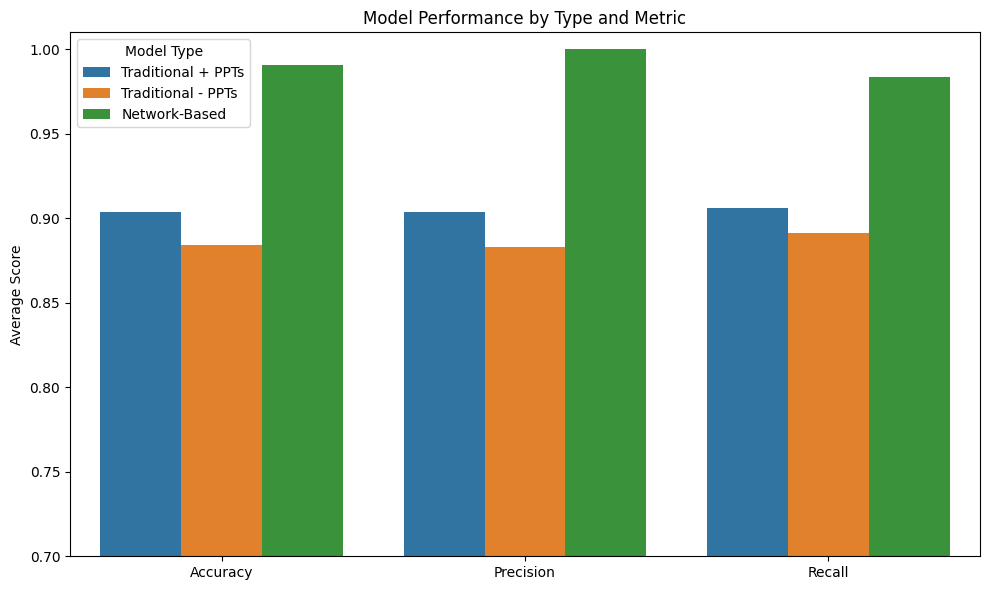

In [56]:
# Visualizing these results:

comparison_df = pd.DataFrame({
    'Model Type': ['Traditional + PPTs', 'Traditional - PPTs', 'Network-Based'],
    'Accuracy': [
        full_TraditionalMLmetrics_df['PPT Accuracy'].mean(),
        full_TraditionalMLmetrics_df['Accuracy'].mean(),
        network_metrics_df['Accuracy'].values[0]
    ],
    'Precision': [
        full_TraditionalMLmetrics_df['PPT Precision'].mean(),
        full_TraditionalMLmetrics_df['Precision'].mean(),
        network_metrics_df['Precision'].values[0]
    ],
    'Recall': [
        full_TraditionalMLmetrics_df['PPT Recall'].mean(),
        full_TraditionalMLmetrics_df['Recall'].mean(),
        network_metrics_df['Recall'].values[0]
    ]
})

melted_df = comparison_df.melt(id_vars='Model Type', var_name='Metric', value_name='Score')

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x='Metric', y='Score', hue='Model Type')
plt.title("Model Performance by Type and Metric")
plt.ylim(0.7, 1.01)
plt.ylabel("Average Score")
plt.xlabel("")
plt.legend(title="Model Type")
plt.grid(axis='y', linestyle='', alpha=0.5)
plt.tight_layout()
plt.show()

<ipython-input-60-8a78bed32695>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(network_metrics_df['Accuracy'])
<ipython-input-60-8a78bed32695>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_accuracy_df, x='Model Category', y='Best Accuracy', palette='Blues_d')


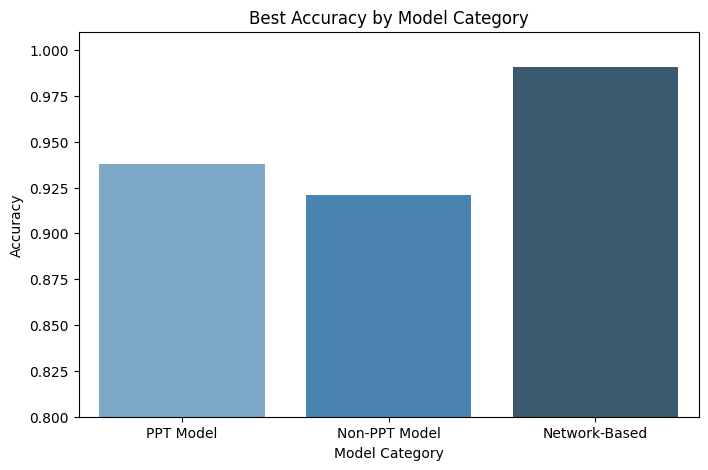

In [60]:
# Comparing Best Performing Models from Each Category

Max_Model_PPT_Accuracy = full_TraditionalMLmetrics_df[full_TraditionalMLmetrics_df['PPT Accuracy'] == full_TraditionalMLmetrics_df['PPT Accuracy'].max()]

Max_Model_nPPT_Accuracy = full_TraditionalMLmetrics_df[full_TraditionalMLmetrics_df['Accuracy'] == full_TraditionalMLmetrics_df['Accuracy'].max()]

best_accuracy_df = pd.DataFrame({
    'Model Category': ['PPT Model', 'Non-PPT Model', 'Network-Based'],
    'Best Accuracy': [
        float(Max_Model_PPT_Accuracy['PPT Accuracy'].values[0]), # Access the first value of the Series
        float(Max_Model_nPPT_Accuracy['Accuracy'].values[0]),    # Access the first value of the Series
        float(network_metrics_df['Accuracy'])
    ]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=best_accuracy_df, x='Model Category', y='Best Accuracy', palette='Blues_d')
plt.ylim(0.8, 1.01)
plt.title("Best Accuracy by Model Category")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='', alpha=0.5)
plt.show()

As we see, the best performing traditional machine learning methods demonstrated respectable accuracy, and it is apparent that the inclusion of PPTs improved model performance ever so slightly. However, these differences are miniscule compared to the network-based approach, which performed with 98.5% accuracy.

## Abbreviated Conclusions

This section provides a quick synopsis of the conclusions of this analysis which will be elaborated on in corresponding presentation & report.

This project set out to study whether the addition of a pscyhological element to phishing detection could improve model performance. This project also attempted to study whether traditional machine learning methods would perform better, equal to, or worse than certain network-based approaches.

Based off this code, it appears that the inclusion of pscyhological trait scoring based off appeals to fear, desire, and urgency slightly improved model performance amongst traditional ML methods. However, network-based approaches offer an even more superior option.

That being said, the feasability of implementation of any of these solutions is dependent upon resources. The network-based approach I implemented was a very simplified approach that accomodated my computational power. For certain organization, implementing network-based technology for phishing email detection could have financial or resource limitations.

Regardless of the solution, it is important that employees constituting the targets of phishing attacks practice diligient, safe information security habits.